In [1]:
# Load library
import sys
import sklearn

import pickle
import numpy as np
import pandas as pd
import cv2
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import csv

print(sys.version)
print('The numpy version is {}.'.format(np.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
The numpy version is 1.19.2.
The pandas version is 1.1.3.
The scikit-learn version is 0.23.2.


In [2]:
# 1001-1-L--2--2009-03-30T15-51-51__2.jpg
def extract_res_from_filename(file_name):
    return int(file_name[(len(file_name) - 29):(len(file_name) - 28)])

def extract_key_from_filename(file_name):
    return (file_name[0:(len(file_name) - 31)])

print(str(extract_res_from_filename("1001-1-L--2--2009-03-30T15-51-51__2.jpg")))
print(str(extract_key_from_filename("1001-1-L--2--2009-03-30T15-51-51__2.jpg")))

2
1001-1-L


In [3]:
# load filter value, 1 is OK for training (auto filter must be run first to obtain auto_filter.csv)
# read from csv
import csv

all_file_auto_filter_saved = {}
count_ok = 0

with open('/Users/phunp/Documents/Flinders/Thesis/data/real_data/auto_filter.csv', mode='r', encoding='UTF8') as csv_datas:
    csv_reader = csv.DictReader(csv_datas)
    for row in csv_reader:
        all_file_auto_filter_saved[row["File Name"]] = (int(row['OK']), float(row['Probability']))
        if int(row['OK']) == 1:
            count_ok += 1


print('there are total of %d OK images ' % (count_ok))
if '101931970A-3-R--3--2010-03-19T11-47-21__0.jpg' in all_file_auto_filter_saved :
    print(all_file_auto_filter_saved['101931970A-3-R--3--2010-03-19T11-47-21__0.jpg'])

there are total of 15231 OK images 
(0, 0.12684077)


In [4]:
# TYMP Data 1-10 - NOT USED
import re

# Load tympanometry data for left and right ears
LABEL_EDID = "EDID"
LABEL_VISIT_NO = "Visit_no"
LABEL_TYMP_LEFT = "L_Tympanometry_class"
LABEL_TYMP_RIGHT = "R_Tympanometry_class"

PATTERN_TYMP_VALID = '^[1-8]$'

def is_valid_tymp_string(tymp_res):
    return tymp_res is not None and bool(re.match(PATTERN_TYMP_VALID, tymp_res))

def convert_tymp_res_to_number(tym_res):
    tymp_res_num = int(tym_res)
    if tymp_res_num in [1,2,3]:
        return 1
    if tymp_res_num in [4,5,6]:
        return 2
    else:
        return 3

df = pd.read_excel(r'/Users/phunp/Documents/Flinders/Thesis/data/real_data/SwimmingPoolData_from Charmaine/CLEAN_ALL.xlsx', 
                   header=4, converters={
                        LABEL_EDID: str,
                        LABEL_TYMP_LEFT: str,
                        LABEL_TYMP_RIGHT: str,
                        LABEL_VISIT_NO: str})
# Put to dict with key: EDID-VisitNo-RorL, value is 1 for pass (1-3), 2 for fail (4-6), 3 for indeterminate (7-8). Ignore for 9, 10 and other invalid result

TYMP_SOURCE = {}

totalRecords = 0
invalidRecords = 0
validRecords = 0

for index, row in df.iterrows():
    totalRecords += 1
    edid = str(row[LABEL_EDID])
    visit_no = str(row[LABEL_VISIT_NO])
    tymp_left = str(row[LABEL_TYMP_LEFT])
    tymp_right = str(row[LABEL_TYMP_RIGHT])
    if edid is None or len(edid) == 0 or visit_no is None or len(visit_no) == 0:
        invalidRecords += 1
        continue;
    if is_valid_tymp_string(tymp_left) or is_valid_tymp_string(tymp_left):
        validRecords += 1
        if is_valid_tymp_string(tymp_left):
            TYMP_SOURCE[edid + "-" + visit_no + "-L"] = convert_tymp_res_to_number(tymp_left)
        if is_valid_tymp_string(tymp_right):
            TYMP_SOURCE[edid + "-" + visit_no + "-R"] = convert_tymp_res_to_number(tymp_right)

print("total record %d, valid record %d, invalid record %d, size of TYMP SOURCE %d" % (totalRecords, validRecords, invalidRecords, len(TYMP_SOURCE)))
                   

total record 2088, valid record 1682, invalid record 0, size of TYMP SOURCE 3243


In [6]:
# TYMP F-P - IN USED
import re

# Load tympanometry data for left and right ears
LABEL_EDID = "EDID"
LABEL_VISIT_NO = "Visit_no"
LABEL_TYMP_LEFT = "L_Tymp_PF"
LABEL_TYMP_RIGHT = "R_Tymp_PF"

PATTERN_TYMP_VALID = '^[PF]$'

def is_valid_tymp_string(tymp_res):
    return tymp_res is None or bool(re.match(PATTERN_TYMP_VALID, tymp_res))

def convert_tymp_res_to_number(tym_res):
    if tym_res is None:
        return 0
    if tym_res == 'P':
        return 1
    if tym_res == 'F':
        return 0
    else:
        return 0

df = pd.read_excel(r'/Users/phunp/Documents/Flinders/Thesis/data/real_data/SwimmingPoolData_from Charmaine/CLEAN_ALL.xlsx', 
                   header=4, converters={
                        LABEL_EDID: str,
                        LABEL_TYMP_LEFT: str,
                        LABEL_TYMP_RIGHT: str,
                        LABEL_VISIT_NO: str})
# Put to dict with key: EDID-VisitNo-RorL, value is 1 for pass, 0 for fail (default 0)

TYMP_SOURCE = {}

totalRecords = 0
invalidRecords = 0
validRecords = 0

for index, row in df.iterrows():
    totalRecords += 1
    edid = str(row[LABEL_EDID])
    visit_no = str(row[LABEL_VISIT_NO])
    tymp_left = str(row[LABEL_TYMP_LEFT])
    tymp_right = str(row[LABEL_TYMP_RIGHT])
    if edid is None or len(edid) == 0 or visit_no is None or len(visit_no) == 0:
        invalidRecords += 1
        continue;
    if is_valid_tymp_string(tymp_left) or is_valid_tymp_string(tymp_left):
        validRecords += 1
        if is_valid_tymp_string(tymp_left):
            TYMP_SOURCE[edid + "-" + visit_no + "-L"] = convert_tymp_res_to_number(tymp_left)
        if is_valid_tymp_string(tymp_right):
            TYMP_SOURCE[edid + "-" + visit_no + "-R"] = convert_tymp_res_to_number(tymp_right)

print("total record %d, valid record %d, invalid record %d, size of TYMP SOURCE %d" % (totalRecords, validRecords, invalidRecords, len(TYMP_SOURCE)))
                   

total record 2088, valid record 2053, invalid record 0, size of TYMP SOURCE 4099


In [7]:
path = '/Users/phunp/Documents/Flinders/Thesis/data/real_data/extract_data_ori/' # path to all images
# read_path = '/Users/phunp/Documents/Flinders/Thesis/data/real_data/extract_data_crop_round/' # path to crop-round of ROI of all images

setSize = set()
# Original shape: 512x640x3
WIDTH = 128
HEIGHT = 160
SIZE = WIDTH * HEIGHT * 3
# IMAGE_COUNT = 11676 # image with tymp data available
IMAGE_COUNT = 15057 # all count
# IMAGE_COUNT = 9275 # count for 1-3-4-5-7 only
LABEL_CONVERTER = {"Normal": 1, "Healed": 2, "Inactive Muc": 3, "Inactive Squa": 4, "Active Muc": 5, "Active Squa": 6, "Fluid OME": 7, "Pus AOM": 8}
# LABEL_CONVERTER = {"Normal": 1, "Inactive Muc": 3, "Inactive Squa": 4, "Active Muc": 5, "Fluid OME": 7}
# CONVERT = {"1": 0, "3": 1, "4": 2, "5": 3, "7": 4}
CONVERT = {"1": 0, "2": 0, "3": 1, "4": 1, "5": 1, "6": 1, "7": 1, "8": 1}

# [[   1 2415]
#  [   2 5952]
#  [   3 2229]
#  [   4 1312]
#  [   5 1872]
#  [   6    4]
#  [   7 1447]]

indexes = {}

def load_images_from_folder(folder):
    X = np.empty((IMAGE_COUNT, SIZE)) # ==> FOR NORMAL
    X_TYMP = np.empty([IMAGE_COUNT], dtype=int)
    # X = np.empty((IMAGE_COUNT, HEIGHT, WIDTH, 3))
    Y = np.empty([IMAGE_COUNT], dtype=int)
    i = 0
    for filename in os.listdir(folder):
        if not filename.endswith(".jpg"):
            continue
        if all_file_auto_filter_saved[filename][0] != 1:
            # file is filtered as bad by auto-filter
            continue
        key = extract_key_from_filename(filename)
        if key not in TYMP_SOURCE:
            continue
        
        label = extract_res_from_filename(filename)

        
#         if label not in [1, 3, 4, 5, 7]:
#             # not include file in category 2, 6 and 8
#             continue
        
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            # resize image to a fix size
            img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
            flatten = img.reshape(-1) # ==> FOR NORMAL MODEL
            # flatten = img # FOR MOBILEV2 NET
            
            X[i] = flatten
            X_TYMP[i] = TYMP_SOURCE[key]
            Y[i] = CONVERT[str(extract_res_from_filename(filename))]
            i = i+1
        if i >= IMAGE_COUNT:
            print("reading max of " + str(IMAGE_COUNT) + "... quit now")
            break;
    
    print("read until i = ", i)
    return X, X_TYMP, Y


X, X_TYMP, y = load_images_from_folder(path)

print(X.shape)
print(X_TYMP.shape)
print(y.shape)

reading max of 15057... quit now
read until i =  15057
(15057, 61440)
(15057,)
(15057,)


In [8]:
# count frequency of all unique values in array
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

# If filter images by tymp res in 1-8 -> input of pass and fail image areL
# [[   0 7864]
#  [   1 3812]]
# Too skew -> go for F and P label of tymp data

[[   0 8293]
 [   1 6764]]


In [10]:
# Merge tymp data as last column of X
X_ALL = np.column_stack((X, X_TYMP.reshape(-1,1)))
print(X_ALL.shape)

# split back
# X = X_ALL[:, :-1]
# X_TYMP = X_ALL[:, -1]


(15057, 61441)


In [30]:
import numpy as np

arr1 = np.array([[1, 2, 3, 4, 5], [11, 12, 13, 14, 15], [21, 22, 23, 24, 25]])
print(arr1.shape)

arr2 = np.array([40, 50, 60])
print(arr2.shape)

print(arr2.reshape(-1,1).shape)

arr = np.column_stack((arr1, arr2.reshape(-1,1)))

print(arr)
print(arr.shape)

# A, B = np.hsplit(arr, 2)
# # A = arr[-1]

print("---" + str(A.shape))
print(A)
print("---" + str(B.shape))
print(B)

(3, 5)
(3,)
(3, 1)
[[ 1  2  3  4  5 40]
 [11 12 13 14 15 50]
 [21 22 23 24 25 60]]
(3, 6)
---(3, 5)
[[ 1  2  3  4  5]
 [11 12 13 14 15]
 [21 22 23 24 25]]
---(3,)
[40 50 60]


In [17]:
# SVC model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

X1_ALL = X_ALL[0:IMAGE_COUNT]
y1 = y[0:IMAGE_COUNT]

# split into train and test
Xtrain_all, Xtest_all, ytrain, ytest = train_test_split(X1_ALL, y1, test_size=0.3, random_state=42, stratify=y1)

# split to X and tymp
Xtrain = Xtrain_all[:, :-1]
Xtrain_tymp = Xtrain_all[:, -1]

Xtest = Xtest_all[:, :-1]
Xtest_tymp = Xtest_all[:, -1]


# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

# do the PCA, choose the numbher of components to retain
input_pca = PCA(n_components=100)
input_pca.fit(Xtrain_std)
Xtrain_std_pca = input_pca.transform(Xtrain_std)
Xtest_std_pca = input_pca.transform(Xtest_std)

C = 10
# model = SVC(kernel='rbf', C=C)
model = SVC(kernel='rbf', C=C, probability=True)
model.fit(Xtrain_std_pca, ytrain)

# print("----------------- Train normal")
# print("Training performance: ")
# y_pred_train = model.predict(Xtrain_std_pca)
# report_train = classification_report(ytrain, y_pred_train)
# print(report_train)

# print("-----------------")
# print("Validation performance: ")
# y_pred = model.predict(Xtest_std_pca)
# report_val = classification_report(ytest, y_pred)
# print(report_val)

print("----------------- Train progba")
y_pred_train = model.predict_proba(Xtrain_std_pca)

y_pred = model.predict_proba(Xtest_std_pca)


----------------- Train progba


In [14]:
print("Validation matthews_corrcoef of single model SVM")
matthews_corrcoef(ytest, y_pred)

Validation matthews_corrcoef of single model SVM


0.5438368722406416

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2488
           1       0.77      0.72      0.74      2030

    accuracy                           0.78      4518
   macro avg       0.77      0.77      0.77      4518
weighted avg       0.77      0.78      0.77      4518



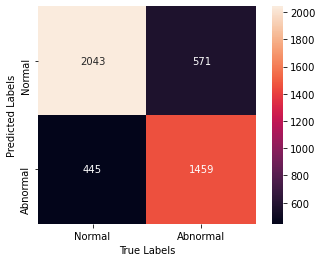

In [15]:
# Confusion metric of single model SVM
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_labels = ["Normal", "Abnormal"]

print(report_val)
mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [73]:
# # Now train again with probability output
# print("-----------------")
# print("Training performance: ")
# y_pred_train = model.predict_proba(Xtrain_std_pca)
# print(y_pred_train.shape)
# print(y_pred_train[0])
# y_pred_train = y_pred_train[:,-1]
# # report_train = classification_report(ytrain, y_pred_train)
# # print(report_train)

# # print("-----------------")
# # print("Validation performance: ")
# y_pred = model.predict_proba(Xtest_std_pca)
# y_pred = y_pred[:,-1]
# # report_val = classification_report(ytest, y_pred)
# # print(report_val)

-----------------
Training performance: 
(10539, 2)
[0.06865178 0.93134822]


(10539, 2)
(10539,)
(10539, 2)
[0.91905335 0.        ]
(4518, 2)


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


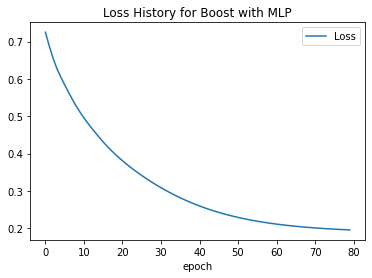

In [19]:
# merge proba with tymp data, feed to mlp
from sklearn.neural_network import MLPClassifier

print(y_pred_train.shape)
print(Xtrain_tymp.shape)

y_pred_train = y_pred_train[:,-1]
y_pred = y_pred[:,-1]


X_train_new = np.column_stack((y_pred_train.reshape(-1,1), Xtrain_tymp.reshape(-1,1)))
print(X_train_new.shape)
print(X_train_new[12])

X_test_new = np.column_stack((y_pred.reshape(-1,1), Xtest_tymp.reshape(-1,1)))
print(X_test_new.shape)


data_name = "Boost with MLP"
hidden_layer_size = 10
max_iter = 80
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), max_iter=max_iter, alpha=0.0001, #try change hidden layer, or max_iter
                    solver='sgd', verbose=0, tol=0.000001, #try verbode=0 to train with out logging
                    early_stopping=False, momentum=0.9) # lbfgs

### Train the Model
# The function call to `fit` trains the model using the training data.  
h = mlp.fit(X_train_new, ytrain)

### Plot a loss curve
# The loss curve shows the history of how the training progressed.
plt.plot(h.loss_curve_)
plt.title('Loss History for ' + data_name)
plt.xlabel('epoch')
plt.legend(['Loss'])

y_pred_new = mlp.predict(X_test_new)

In [22]:
# metrics for boost models
from sklearn.metrics import f1_score
print()
print('Evaluation of hidden_layer_size: {}, max_iter: {}'.format(hidden_layer_size, max_iter))
print()
# y_pred_new = mlp.predict(X_test_new)
cm = confusion_matrix(ytest, y_pred_new,normalize=None)
cr = classification_report(ytest,y_pred_new)
print(cr)
f1 = f1_score(ytest, y_pred_new,average='weighted')
cm = confusion_matrix(ytest, y_pred_new)
bm = calculate_bm(cm)
print('Bookmaker for {0} is {1:.2f}'.format(data_name,bm))
print("Validation matthews_corrcoef")
matthews_corrcoef(ytest, y_pred_new)


Evaluation of hidden_layer_size: 10, max_iter: 80

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2488
           1       0.81      0.79      0.80      2030

    accuracy                           0.82      4518
   macro avg       0.82      0.82      0.82      4518
weighted avg       0.82      0.82      0.82      4518

Bookmaker for Boost with MLP is 0.64
Validation matthews_corrcoef


0.6367419297346575

In [76]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_new, ytrain)

y_pred_new = dt.predict(X_test_new)

In [78]:
# from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
# from pydot import graph_from_dot_data
from IPython.display import Image 
from sklearn import tree

text_representation = tree.export_text(dt)
print(text_representation)

for i in range(0,20):
    print("X: " + str(X_train_new[i]) + " -> " + str(ytrain[i]))

# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data, feature_names=["Image Predict", "Tymp"])
# (graph, ) = graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png())

|--- feature_0 <= 0.47
|   |--- feature_0 <= 0.23
|   |   |--- feature_0 <= 0.17
|   |   |   |--- feature_1 <= 0.50
|   |   |   |   |--- feature_0 <= 0.17
|   |   |   |   |   |--- feature_0 <= 0.17
|   |   |   |   |   |   |--- feature_0 <= 0.08
|   |   |   |   |   |   |   |--- feature_0 <= 0.06
|   |   |   |   |   |   |   |   |--- feature_0 <= 0.04
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.04
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_0 >  0.04
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_0 >  0.04
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_0 >  0.06
|   |   |   |   |   |   |   |   |--- feature_0 <= 0.06
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_0 >  0.06
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.06
|   |   |   |   |   |   |   |   |   |   |--- fea

In [33]:
print("Training matthews_corrcoef")
matthews_corrcoef(ytrain, y_pred_train)

Training matthews_corrcoef


0.8375876024787821

In [23]:
print("Validation matthews_corrcoef")
matthews_corrcoef(ytest, y_pred_new)

Validation matthews_corrcoef


0.6367419297346575

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2488
           1       0.81      0.79      0.80      2030

    accuracy                           0.82      4518
   macro avg       0.82      0.82      0.82      4518
weighted avg       0.82      0.82      0.82      4518



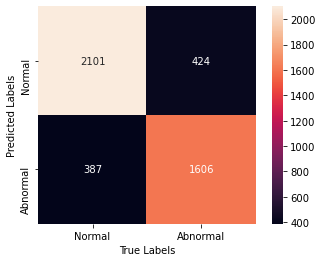

In [24]:
# confusion metric for boost model

from sklearn.metrics import confusion_matrix
import seaborn as sns

class_labels = ["Normal", "Abnormal"]

# print(report_val)
print(classification_report(ytest, y_pred_new))
mat = confusion_matrix(ytest, y_pred_new)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [35]:
# Grid search for hyperparameter tuning SVM
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
std = StandardScaler()
pca = PCA(n_components=50)
svc = SVC(kernel='rbf')
pipe_svc = Pipeline([('std',std),('pca', pca),('svc',svc)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_svc = {
    'pca__n_components': [10, 50, 100],
    'svc__kernel': ['rbf', 'linear', 'sigmoid'],
    'svc__C': [0.1, 1, 10],
    #'svc__gamma' : np.logspace(-9, 9, num=20, base=10)
}

search_svc = GridSearchCV(pipe_svc, param_grid_svc,
                      scoring="accuracy",
                      #cv=StratifiedKFold(n_splits=2),
                      cv=5, # default to stratified
                      verbose=3, 
                      #n_jobs=3, enable n_jobs did not give any logs. I want logs
                         )
%time search_svc.fit(Xtrain, ytrain)
print("Best parameter (CV score=%0.3f):" % search_svc.best_score_)
print(search_svc.best_params_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 17.7min finished


CPU times: user 14min 22s, sys: 8min 37s, total: 23min
Wall time: 20min 43s
Best parameter (CV score=0.382):
{'pca__n_components': 20, 'svc__C': 1000000000.0, 'svc__gamma': 1000000000.0, 'svc__kernel': 'rbf'}


In [37]:
best_model_svc = search_svc.best_estimator_
yfit = best_model_svc.predict(Xtest)
print(best_model_svc)

class_labels = ["Normal", "Abnormal"]

print(classification_report(ytest,yfit))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

NameError: name 'search_svc' is not defined

In [21]:
def calculate_bm(cm):

    TN = cm[1][1]
    FN = cm[0][1]
    TP = cm[0][0]
    FP = cm[1][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    F1 = 2*(PPV*TPR)/(PPV+TPR)
    BM = TPR + TNR - 1

    return BM


Evaluation of hidden_layer_size: 500, max_iter: 1000

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      2510
           1       0.73      0.71      0.72      2060

    accuracy                           0.75      4570
   macro avg       0.75      0.75      0.75      4570
weighted avg       0.75      0.75      0.75      4570

Bookmaker for MLP model is 0.50
Validation matthews_corrcoef


/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.49841935889859645

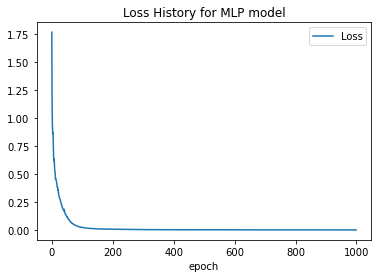

In [11]:
# MLP Model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier

X1 = X[0:IMAGE_COUNT]
y1 = y[0:IMAGE_COUNT]

# split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y1,test_size=0.3, random_state=42, stratify=y1)

# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

# do the PCA, choose the numbher of components to retain
input_pca = PCA(n_components=100)
input_pca.fit(Xtrain_std)
Xtrain_std_pca = input_pca.transform(Xtrain_std)
Xtest_std_pca = input_pca.transform(Xtest_std)

## MLP PART
data_name = "MLP model"
# model initialization
hidden_layer_size = 500
max_iter = 1000
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), max_iter=max_iter, alpha=0.0001, #try change hidden layer, or max_iter
                    solver='sgd', verbose=0, tol=0.000001, #try verbode=0 to train with out logging
                    early_stopping=False, momentum=0.9) # lbfgs

### Train the Model
# The function call to `fit` trains the model using the training data.  
h = mlp.fit(Xtrain_std_pca, ytrain)

### Plot a loss curve
# The loss curve shows the history of how the training progressed.
plt.plot(h.loss_curve_)
plt.title('Loss History for ' + data_name)
plt.xlabel('epoch')
plt.legend(['Loss'])


## Evaluate the performance of the classifier
# Let's have a look at predicting the first 10 instances in the test data set.  How did it do?  How many matches?
# print('predictions: {0}'.format(mlp.predict(Xtest_std_pca[0:10,:])))
# print('acutal     : {0}'.format(np.ravel(ytest)[0:10]))

# Calculate evaluation measures
print()
print('Evaluation of hidden_layer_size: {}, max_iter: {}'.format(hidden_layer_size, max_iter))
print()
y_pred = mlp.predict(Xtest_std_pca)
cm = confusion_matrix(ytest, y_pred,normalize=None)
cr = classification_report(ytest,y_pred)
print(cr)
f1 = f1_score(ytest, y_pred,average='weighted')
cm = confusion_matrix(ytest, y_pred)
bm = calculate_bm(cm)
print('Bookmaker for {0} is {1:.2f}'.format(data_name,bm))
print("Validation matthews_corrcoef")
matthews_corrcoef(ytest, y_pred)


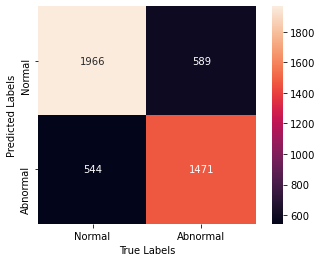

In [13]:
# Confusion matrix for mlp
mat = confusion_matrix(ytest, y_pred)

class_labels = ["Normal", "Abnormal"]

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
std = StandardScaler()
pca = PCA(n_components=100)
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), max_iter=max_iter, alpha=0.001, #try change hidden layer, or max_iter
                    solver='sgd', verbose=0, tol=0.000001, #try verbode=0 to train with out logging
                    early_stopping=False, momentum=0.9)
pipe_mlp = Pipeline([('std',std),('pca', pca),('mlp',mlp)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_mlp = {
    'pca__n_components': [10, 50, 100],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__max_iter': [500, 1000],
    'mlp__hidden_layer_sizes': [(100), (250), (500)],
#   'svc__gamma' : np.logspace(-9, 9, num=2, base=10)
}


search_mlp = GridSearchCV(pipe_mlp, param_grid_mlp,
                      scoring="accuracy",
                      #cv=StratifiedKFold(n_splits=2),
                      cv=5,
                      verbose=3, 
                      n_jobs=3,
                         )
%time search_mlp.fit(Xtrain, ytrain)
print("Best parameter (CV score=%0.3f):" % search_mlp.best_score_)
print(search_mlp.best_params_)


In [ ]:
best_model_mlp = search_mlp.best_estimator_
yfit = best_model_mlp.predict(Xtest)
print(best_model_mlp)

class_labels = ["Normal", "Abnormal"]

print(classification_report(ytest,yfit))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

In [14]:
# Build CNN Model

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Dense, Dropout,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler

def build_cnn_model(X, y):
    # construct model
    shape = (WIDTH, HEIGHT, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), padding = 'same',activation = 'relu', input_shape = shape))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128,activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(2,activation = 'softmax')) # softmax. linear

    opt = SGD(lr=0.01)
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

Using TensorFlow backend.
/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/phunp/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/phunp/o

In [15]:
# Note not run yet from this point UPSETTT
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

y2 = y
X2 = X
# X2 = X2.reshape((IMAGE_COUNT, WIDTH, HEIGHT, 3))
# X2 = X2/255
# X2 = X2 / 255
# print(X.shape)
# X2 = X2.reshape((IMAGE_COUNT,WIDTH,HEIGHT,3))
#update y to one hot encode
# onehot_encoder = OneHotEncoder(sparse=False)
# y_encoded = y2.reshape(len(y2), 1)
# y2h = onehot_encoder.fit_transform(y_encoded)
y2 = to_categorical(y2)

Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)
# print("X train shape " + str(Xtrain.shape))
# normalise features
input_std = StandardScaler()
input_std.fit(Xtrain)
Xtrain_std = input_std.transform(Xtrain)
Xtest_std = input_std.transform(Xtest)

Xtrain_std = Xtrain_std.reshape((-1, WIDTH, HEIGHT, 3))
Xtest_std = Xtest_std.reshape((-1, WIDTH, HEIGHT, 3))

no_epochs = 20
model = build_cnn_model(Xtrain_std, ytrain)

print('Training with for {0} epochs'.format(no_epochs))
history = model.fit(Xtrain_std, ytrain, validation_split = 0.2, epochs=no_epochs, verbose=1)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


loss_final = np.sqrt(float(hist['loss'].tail(1)))
print()
print('Final Loss on training set: {}'.format(round(loss_final, 3)))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 128)     

In [16]:
hist

,val_loss,val_accuracy,loss,accuracy,epoch
0,1.515030,0.388761,1.576848,0.279800,0
1,1.445059,0.396459,1.477411,0.383401,1
2,1.437002,0.406467,1.411997,0.405546,2
3,1.437989,0.379523,1.358229,0.432890,3
4,1.410226,0.411085,1.326839,0.450221,4
5,1.600636,0.342571,1.282896,0.471596,5
6,1.487836,0.369515,1.231610,0.502600,6
7,1.409111,0.410316,1.185721,0.518583,7
8,1.348530,0.451116,1.127954,0.545735,8
9,1.410365,0.462664,1.046362,0.587329,9


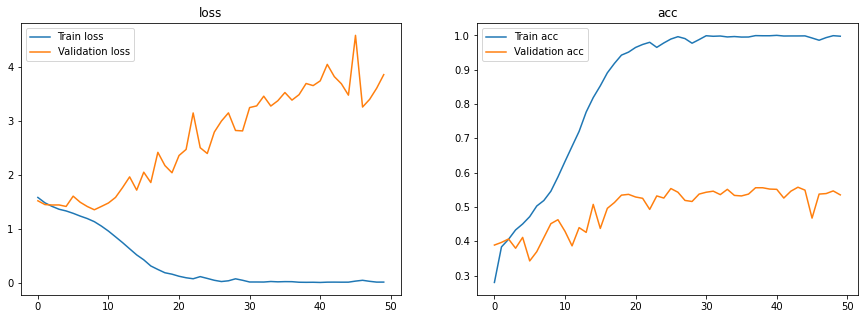

In [17]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

show_final_history(history)

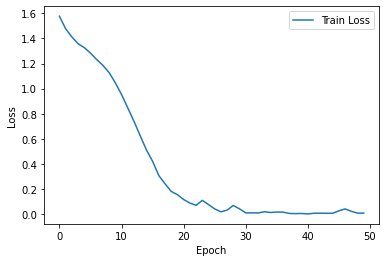

In [18]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.legend()

plot_history()

In [19]:
[loss, crossent] = model.evaluate(Xtest_std, ytest)
print('Loss on test set: {}'.format(round(loss, 3)))
y_pred_real = model.predict(Xtest_std)
y_pred = np.argmax(y_pred_real, axis=-1)


ytest_for_report = np.argmax(ytest, axis=-1)
cr = classification_report(ytest_for_report,y_pred)
print(cr)
f1 = f1_score(ytest_for_report, y_pred,average='weighted')
cm = confusion_matrix(ytest_for_report, y_pred)
print(cm)

print("Training matthews_corrcoef")
matthews_corrcoef(ytest_for_report, y_pred)

2783/2783 [==============================] - 19s 7ms/step
Loss on test set: 3.887
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       724
           1       0.54      0.58      0.56       669
           2       0.44      0.40      0.42       394
           3       0.55      0.44      0.49       562
           4       0.45      0.41      0.43       434

    accuracy                           0.53      2783
   macro avg       0.51      0.50      0.51      2783
weighted avg       0.52      0.53      0.52      2783

[[501  63  64  41  55]
 [ 81 388  48  93  59]
 [100  64 156  32  42]
 [ 78 142  35 247  60]
 [102  66  53  34 179]]
Training matthews_corrcoef


0.40018017430550745

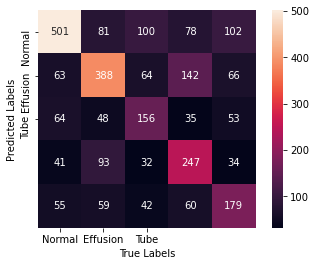

In [20]:
# Confusion matrix for cnn
mat = confusion_matrix(ytest_for_report, y_pred)

class_labels = ["Normal", "Abnormal"]

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels
            )
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');